In [1]:
import osmnx as ox
import geopandas as gpd
from shapely.ops import unary_union
from shapely.geometry import box
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

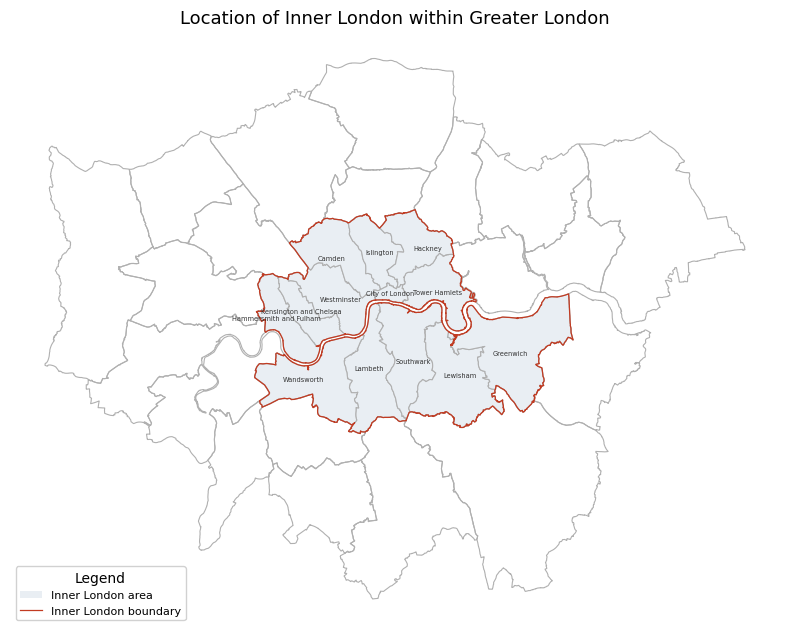

In [2]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import os

# Style Parameters
FIGSIZE = (8, 8)
TITLE = "Location of Inner London within Greater London"
OUTPUT_DIR = "output/3"
OUTPUT_FILE = "inner_london_location.png"

OUTER_BORO_BOUNDARY_COLOR = "#b0b0b0"
OUTER_BORO_BOUNDARY_WIDTH = 0.8

INNER_FILL_COLOR = "#e9eef3"       
INNER_BORO_BOUNDARY_COLOR = "#b0b0b0"   
INNER_BORO_BOUNDARY_WIDTH = 0.8

INNER_DISSOLVE_OUTLINE_COLOR = "#c23b22"
INNER_DISSOLVE_OUTLINE_WIDTH = 0.9

LABEL_FONTSIZE = 4.8
LABEL_COLOR = "#333333"

# Data
gdf = gpd.read_file("data/ESRI/London_Borough_Excluding_MHW.shp")
inner_borough_names = [
    "Camden","Islington","Hackney","Tower Hamlets","Westminster",
    "Kensington and Chelsea","Hammersmith and Fulham","Lambeth",
    "Southwark","Wandsworth","Lewisham","Greenwich","City of London"
]
outer_london = gdf[~gdf["NAME"].isin(inner_borough_names)]
inner_london = gdf[gdf["NAME"].isin(inner_borough_names)]
inner_london_union = inner_london.dissolve()

# Plotting
fig, ax = plt.subplots(figsize=FIGSIZE)

outer_london.boundary.plot(ax=ax, color=OUTER_BORO_BOUNDARY_COLOR, linewidth=OUTER_BORO_BOUNDARY_WIDTH)

inner_london.plot(ax=ax, facecolor=INNER_FILL_COLOR,
                  edgecolor=INNER_BORO_BOUNDARY_COLOR, linewidth=INNER_BORO_BOUNDARY_WIDTH)

inner_london_union.boundary.plot(ax=ax, color=INNER_DISSOLVE_OUTLINE_COLOR,
                                 linewidth=INNER_DISSOLVE_OUTLINE_WIDTH)

for _, row in inner_london.iterrows():
    pt = row.geometry.representative_point()
    ax.text(pt.x, pt.y, row["NAME"], ha="center", va="center",
            fontsize=LABEL_FONTSIZE, color=LABEL_COLOR)
legend_elements = [
    Patch(facecolor=INNER_FILL_COLOR, edgecolor="none", label="Inner London area"),
    Line2D([0],[0], color=INNER_DISSOLVE_OUTLINE_COLOR, lw=INNER_DISSOLVE_OUTLINE_WIDTH, label="Inner London boundary"),
]
leg = ax.legend(handles=legend_elements, loc="lower left", fontsize=8, title="Legend", frameon=True)
leg.get_frame().set_alpha(0.9)

ax.set_title(TITLE, fontsize=13)
ax.axis("off")
plt.tight_layout()

# Save + display
os.makedirs(OUTPUT_DIR, exist_ok=True)
out = os.path.join(OUTPUT_DIR, OUTPUT_FILE)
plt.savefig(out, dpi=300, bbox_inches="tight")
plt.show()

In [3]:
# London borough shapefile
gdf = gpd.read_file("data/ESRI/London_Borough_Excluding_MHW.shp")

print(sorted(gdf["NAME"].unique()))

inner_borough_names = [
    "Camden",
    "Islington",
    "Hackney",
    "Tower Hamlets",
    "Westminster",
    "Kensington and Chelsea",
    "Hammersmith and Fulham",
    "Lambeth",
    "Southwark",
    "Wandsworth",
    "Lewisham",
    "Greenwich",
    "City of London"
]
inner_london = gdf[gdf["NAME"].isin(inner_borough_names)].dissolve()

['Barking and Dagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley', 'Camden', 'City of London', 'Croydon', 'Ealing', 'Enfield', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Haringey', 'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington', 'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham', 'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton', 'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster']


In [4]:
inner_proj = inner_london.to_crs(epsg=27700)

geom = inner_proj.geometry.values[0]

#Apply a small buffer (50 m) to fuse gaps
fused = geom.buffer(50)

#Create 1.5 km buffer (subtracting the 50 m added earlier)
buffer_geom = fused.buffer(1450)

#Convert back to WGS84 (EPSG:4326) for OSM download
buffer_wgs = gpd.GeoDataFrame(geometry=[buffer_geom], crs="EPSG:27700").to_crs(epsg=4326)

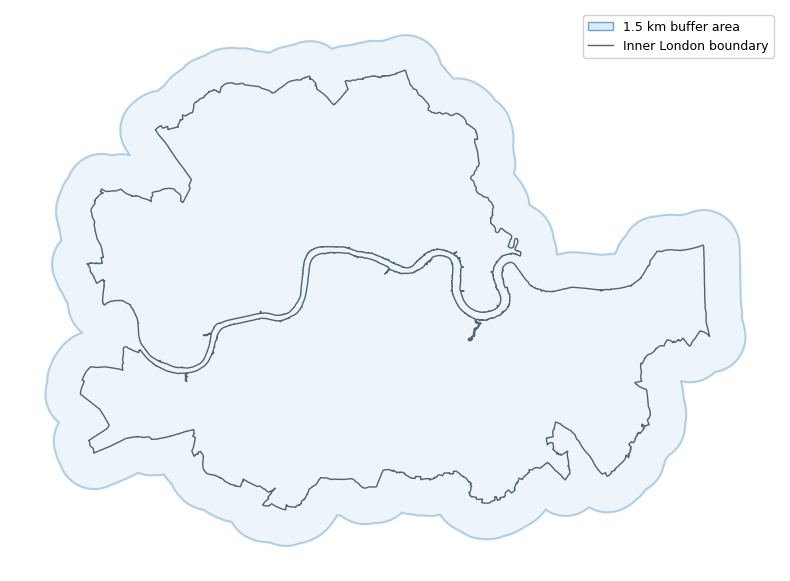

In [5]:
# visualizes the 1.5 km buffer around Inner London

os.makedirs("output/3", exist_ok=True)

fig, ax = plt.subplots(figsize=(8, 8))

buffer_wgs.plot(
    ax=ax,
    facecolor='#dcebf7',        
    edgecolor='#6aa6d1',        
    linewidth=1.5,              
    alpha=0.5
)

inner_london.to_crs(epsg=4326).plot(
    ax=ax,
    edgecolor='#4f6475',
    facecolor='none',
    linewidth=1.0
)

legend_elements = [
    Patch(facecolor='#dcebf7', edgecolor='#6aa6d1', label='1.5 km buffer area'),
    Line2D([0], [0], color='#4f6475', lw=1.0, label='Inner London boundary')
]
ax.legend(
    handles=legend_elements,
    loc='upper right',
    fontsize=9,
    frameon=True
).get_frame().set_alpha(0.9)

ax.axis("off")
plt.tight_layout()

output_path = "output/3/inner_london_buffer.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()



In [6]:
#save
buffer_wgs.to_file("output/inner_london_buffer.geojson", driver="GeoJSON")

In [7]:
# Download walking network within the buffer area
polygon = buffer_wgs.geometry.values[0] 
G_walk = ox.graph_from_polygon(polygon, network_type='walk')

In [8]:
# Save the walking network as GraphML
ox.save_graphml(G_walk, filepath="output/inner_london_walk.graphml")

In [9]:
# Basic stats: number of nodes and edges
print(f"Walk network nodes: {G_walk.number_of_nodes()}")
print(f"Walk network edges: {G_walk.number_of_edges()}")

Walk network nodes: 210030
Walk network edges: 547464


Highway types in the Inner London 'walk' network:
 - unclassified
 - residential
 - footway
 - service
 - primary
 - secondary
 - trunk
 - secondary_link
 - tertiary
 - pedestrian
 - primary_link
 - tertiary_link
 - steps
 - path
 - trunk_link
 - living_street
 - track
 - bridleway
 - corridor
 - road
 - busway
 - elevator


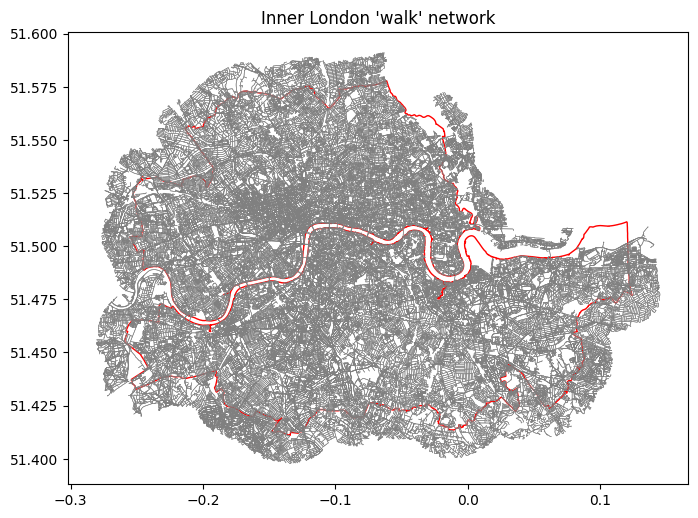

In [10]:
# Convert walk network to GeoDataFrames

nodes_walk, edges_walk = ox.graph_to_gdfs(G_walk)

# Check highway types included in the walk network
walk_types = edges_walk['highway'].explode().unique()
print("Highway types in the Inner London 'walk' network:")
for t in walk_types:
    print(" -", t)

# Visualize the walk network
fig, ax = plt.subplots(figsize=(8, 8))
edges_walk.plot(ax=ax, linewidth=0.4, color='gray')
inner_london.to_crs(epsg=4326).plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1)
plt.title("Inner London 'walk' network")
plt.show()

In [11]:
# Download cycling (bike) network within the buffer area
G_bike = ox.graph_from_polygon(polygon, network_type='bike')
nodes_bike, edges_bike = ox.graph_to_gdfs(G_bike)

In [12]:
# Basic stats: number of nodes and edges
print(f"Bike network nodes: {G_bike.number_of_nodes()}")
print(f"Bike network edges: {G_bike.number_of_edges()}")

Bike network nodes: 125090
Bike network edges: 286152


Highway types in the Inner London 'bike' network:
 - unclassified
 - residential
 - trunk
 - primary
 - secondary
 - service
 - secondary_link
 - tertiary
 - pedestrian
 - cycleway
 - primary_link
 - tertiary_link
 - path
 - living_street
 - trunk_link
 - bridleway
 - track
 - busway
 - road


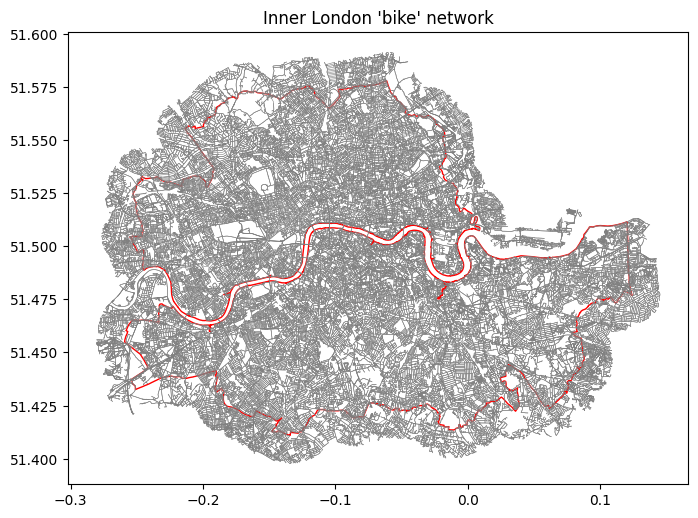

In [13]:
# Convert bike network to GeoDataFrames
nodes_bike, edges_bike = ox.graph_to_gdfs(G_bike)

# Check highway types in the bike network
bike_types = edges_bike["highway"].explode().unique()
print("Highway types in the Inner London 'bike' network:")
for t in bike_types:
    print(" -", t)

# Visualize the bike network
fig, ax = plt.subplots(figsize=(8, 8))
edges_bike.plot(ax=ax, linewidth=0.4, color="gray")
inner_london.to_crs(epsg=4326).plot(ax=ax, edgecolor="red", facecolor="none", linewidth=1)
plt.title("Inner London 'bike' network")
plt.show()

In [ ]:
# Project bike edges to British National Grid
edges_projected_bike = edges_bike.to_crs(epsg=27700)  
sample_points_bike = []

# Generate sample points every ~100 meters along each edge
for idx, row in edges_projected_bike.iterrows():
    line = row.geometry
    length= line.length 
    
   # Number of segments (1 point every 100 m)
    n_segments = int(np.ceil(length / 100))  # 每100m一个采样段
    n_points = n_segments + 1  # 采样点 = 段数 + 起点
    
   # Interpolate points along the line
    for i in range(n_points):
        point = line.interpolate(i / n_segments, normalized=True)
        sample_points_bike.append(Point(point.x, point.y))

# Convert to GeoDataFrame and reproject to WGS84 (EPSG:4326) for Google Street View queries
gdf_samples_bike = gpd.GeoDataFrame(geometry=sample_points_bike, crs="EPSG:27700").to_crs(epsg=4326)

# Visualization check
ax = edges_bike.plot(figsize=(10, 10), color='gray', linewidth=0.3)
gdf_samples_bike.plot(ax=ax, color='red', markersize=2)
plt.title("Street View sample points (bike)")
plt.show()

In [ ]:
# Stats
print("Number of sample points in bike network:", len(gdf_samples_bike))
print("Total bike edges:", len(edges_projected_bike))
print("Unique geometries:", edges_projected_bike.geometry.apply(lambda g: g.wkb).nunique())

## Merge walking and cycling networks

In [ ]:
import networkx as nx
G_combined = nx.compose(G_walk, G_bike)

In [ ]:
import osmnx as ox
import matplotlib.pyplot as plt

# visualize combined network
fig, ax = ox.plot_graph(
    G_combined,
    node_size=0,
    edge_color="gray",
    edge_linewidth=0.6,
    bgcolor="white"
)

In [ ]:
# Basic stats
print(f"Combined network nodes: {G_combined.number_of_nodes()}")
print(f"Combined network edges: {G_combined.number_of_edges()}")

# Save combined network to GraphML
ox.save_graphml(G_combined, filepath="output/G_combined_final.graphml")

In [ ]:
# Explode 'highway' column for both walk and bike edges
edges_walk = edges_walk.explode('highway')
edges_bike = edges_bike.explode('highway')

# Concatenate and remove duplicates
edges_combined = pd.concat([edges_walk, edges_bike]).drop_duplicates(subset=['geometry', 'highway'])
edges_combined["wkb"] = edges_combined.geometry.apply(lambda g: g.wkb)
edges_combined = edges_combined.drop_duplicates(subset="wkb").drop(columns="wkb")

#  Remove unwanted highway types (e.g. 'corridor')
edges_combined = edges_combined[~edges_combined['highway'].isin(['corridor'])]

In [ ]:
# visualizing

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.patheffects as pe  

BUF_FACE   = '#dcebf7'   
BUF_EDGE   = '#6aa6d1'   
BUF_ALPHA  = 0.55        
BUF_W      = 1.4

NET_COLOR  = '#555555'   
NET_W      = 0.24        
NET_ALPHA  = 0.88

INNER_EDGE = '#8B0000'  
INNER_W    = 0.7        

fig, ax = plt.subplots(figsize=(8, 8))

buffer_wgs.plot(ax=ax, facecolor=BUF_FACE, edgecolor='none', alpha=BUF_ALPHA, zorder=1)
buffer_wgs.boundary.plot(ax=ax, color=BUF_EDGE, linewidth=BUF_W, zorder=2)

edges_combined.to_crs(epsg=4326).plot(
    ax=ax, color=NET_COLOR, linewidth=NET_W, alpha=NET_ALPHA, zorder=3
)

inner_london.to_crs(epsg=4326).boundary.plot(
    ax=ax, color=INNER_EDGE, linewidth=INNER_W, zorder=4
)

for line in ax.get_lines()[-1:]:
    line.set_path_effects([pe.withStroke(linewidth=INNER_W+0.8, foreground=(1,1,1,0.45))])

legend_items = [
    Patch(facecolor=BUF_FACE, edgecolor=BUF_EDGE, label='1.5 km buffer area', alpha=BUF_ALPHA),
    Line2D([0],[0], color=NET_COLOR, lw=0.8, label='Pedestrian network'),
    Line2D([0],[0], color=INNER_EDGE, lw=INNER_W, label='Inner London boundary'),
]
leg = ax.legend(handles=legend_items, loc='upper right', fontsize=9, frameon=True)
leg.get_frame().set_alpha(0.9)

ax.axis('off')
plt.tight_layout()
plt.savefig("output/3/inner_london_network.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# Check highway types in the combined network
combined_types = edges_combined['highway'].explode().unique()
print("Inner London 'combined' 道路类型有：")
for t in combined_types:
    print(" -", t)

In [ ]:
# Project edges to British National Grid
edges_projected = edges_combined.to_crs(epsg=27700) 
sample_points = []

In [ ]:
# Iterate over each edge and generate sample points (~100 m spacing)
for idx, row in edges_projected.iterrows():
    line = row.geometry
    length = line.length   # length in meters
    
    # Number of segments (1 point every 100 m)
    n_segments = int(np.ceil(length / 100))
    n_points = n_segments + 1   # segments + start point
    
    # Interpolate sample points along the line
    for i in range(n_points):
        point = line.interpolate(i / n_segments, normalized=True)  # normalized: 0–1
        sample_points.append(Point(point.x, point.y))

# Convert to GeoDataFrame and reproject to WGS84 (EPSG:4326) for Google Street View download
gdf_samples = gpd.GeoDataFrame(geometry=sample_points, crs="EPSG:27700").to_crs(epsg=4326)

# Remove duplicate points 
gdf_samples_delete = gdf_samples.drop_duplicates(subset="geometry")

# Check number of duplicate points
duplicates = gdf_samples[gdf_samples.duplicated(subset="geometry", keep=False)]
print("Total duplicate points:", len(duplicates))

In [ ]:
print("Total number of sampling points:", len(gdf_samples_delete))

In [ ]:
# # Visualization check
fig, ax = plt.subplots(figsize=(10, 10))

edges_combined.plot(ax=ax, color="#d9d9d9", linewidth=0.3, zorder=1)

gdf_samples_delete.plot(
    ax=ax, 
    color="#ff4d4d",  
    markersize=0.1,    
    zorder=2
)

plt.title("Distribution of Street View Sampling Points", fontsize=14)
plt.axis("off")  
plt.tight_layout()

plt.savefig("output/3/sampling_points_distribution.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# Export to shapefile
gdf_samples_delete.to_file("out/samles/samples_delete.shp")